In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm

from sim_cosmology import p, load_dataloader_and_pretrained_model
p.data_path = '../../src/dsets/cosmology/data'
p.model_path = '../../src/dsets/cosmology/data'
# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_1dfilts, get_2dfilts
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data and model

In [5]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)

# # check prediction
# with torch.no_grad():
#     result = {'y': [], 'pred': []}
#     for data, params in train_loader:
#         result['y'].append(params[:,1].detach().cpu())
#         result['pred'].append(model(data.to(device))[:,1].detach().cpu())
# plt.scatter(torch.cat(result['y']), torch.cat(result['pred']))
# plt.xlabel('true param')
# plt.ylabel('predicted param')
# plt.show()  

In [6]:
# get image
data = iter(test_loader).next()[0].to(device)

# wavelet transform 
wt = DWT2d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.1).to(device)

data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 2d wavelet filters
filt = get_2dfilts(wt)

Reconstruction error=547.48944


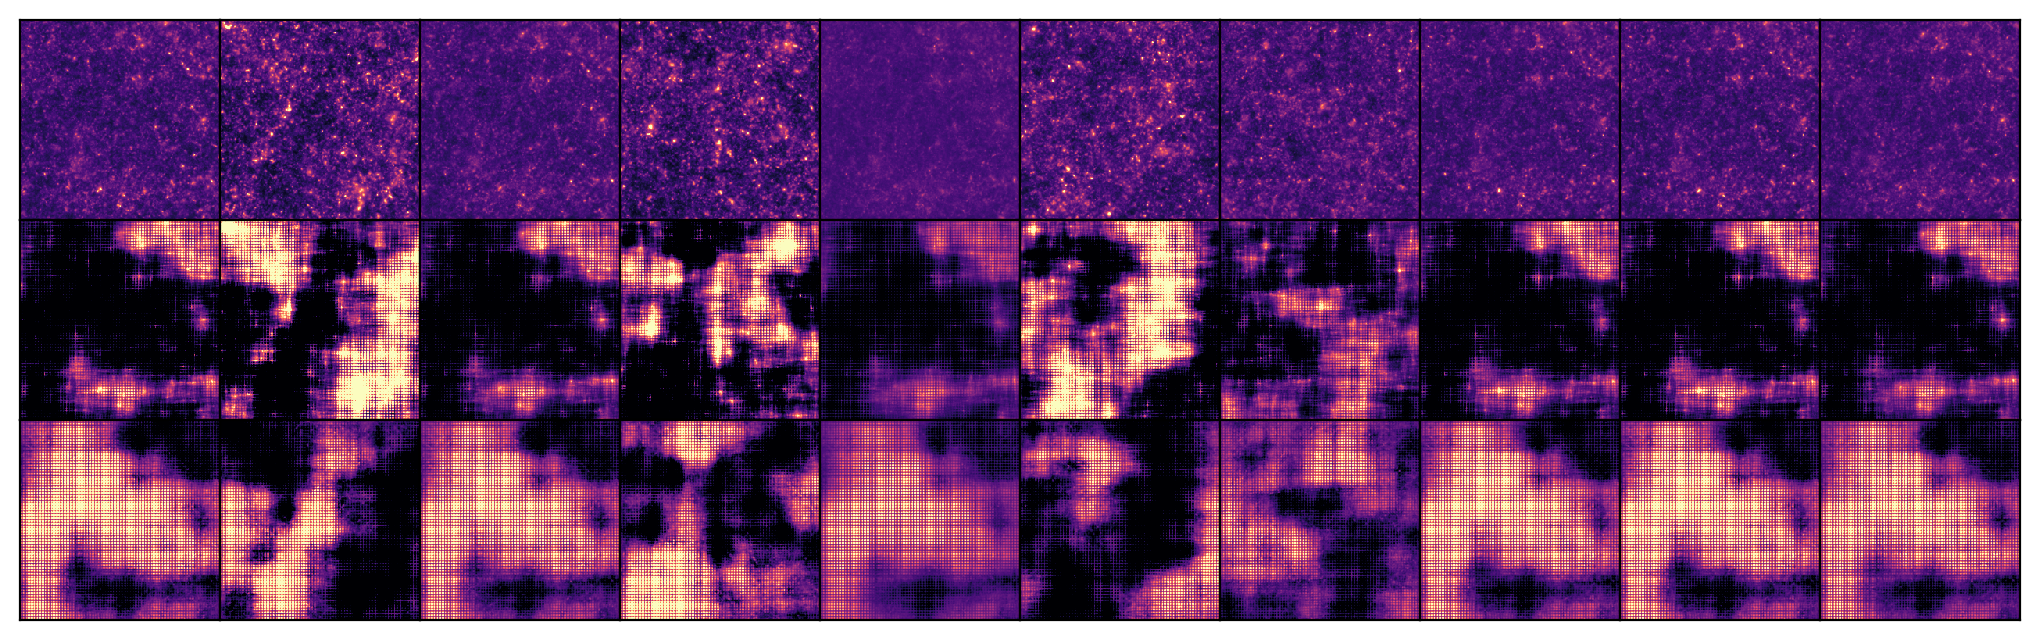

In [7]:
# plot original and reconstruction images
plot_2dreconstruct(data, recon)

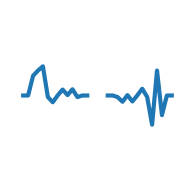

In [8]:
# plot wavelet filters
plot_1dfilts(filt[0], figsize=(1,1))

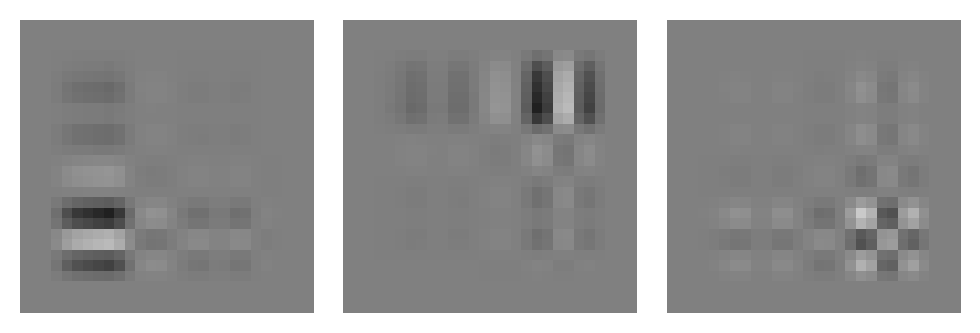

In [9]:
# plot wavelet filters
plot_2dfilts(filt[1], figsize=(5,5))

## optimize filter

In [11]:
# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
loss_f = get_loss_f(lamSum=1, lamL2norm=1, lamCMF=1, lamL1wave=0.0, lamL1attr=1.0)
trainer = Trainer(model, wt, optimizer, loss_f, target=1, 
                  use_residuals=True, attr_methods='Saliency', device=device, n_print=50)

In [12]:
trainer(train_loader, epochs=1)

Starting Training Loop...
Train Epoch: 0 [15600/25000 (100%)]	Loss: 84.619873
====> Epoch: 0 Average train loss: 103.4235


[autoreload of sim_cosmology failed: Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/ubuntu/adaptive-wavelets/notebooks/ex_cosmology/sim_cosmology.py", line 25, in <module>
    fro

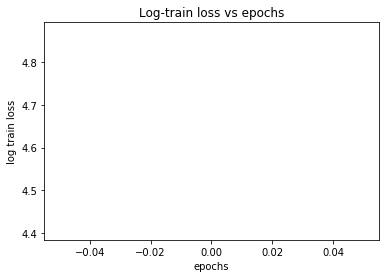

In [13]:
plt.plot(np.log(trainer.train_losses))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [14]:
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 2d wavelet filters
filt = get_2dfilts(wt)

Reconstruction error=7.54955


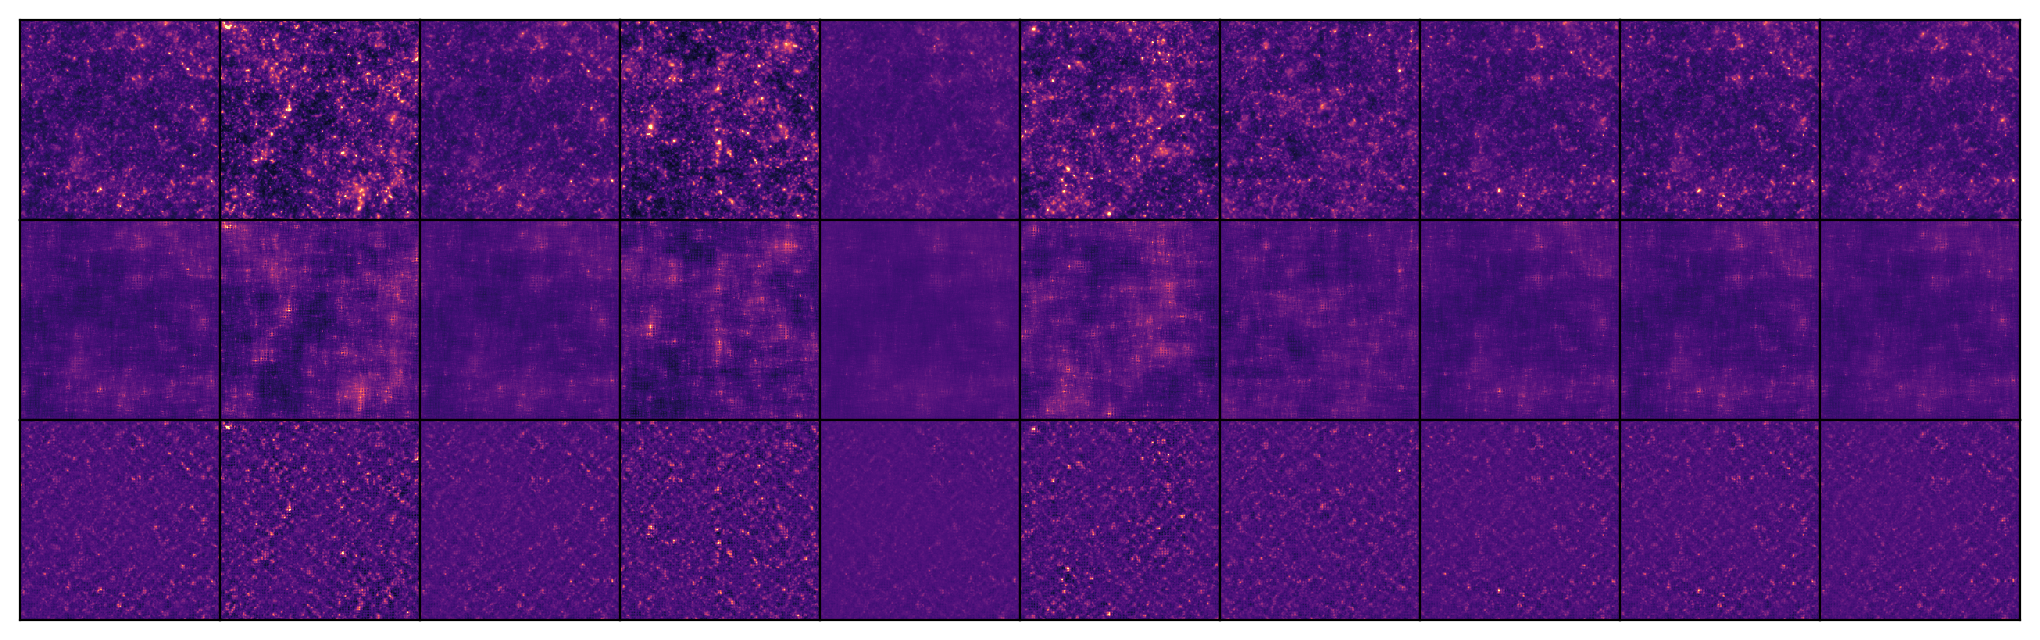

In [15]:
# plot original and reconstruction images
plot_2dreconstruct(data, recon)

## test error

In [ ]:
# validator 
validator = Validator(model, test_loader)
rec_loss, sum_loss, L2norm_loss, CMF_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss = validator(wt, target=1)

# original wavelet transform
wt_o = DWT2d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0).to(device)
rec_loss_o, sum_loss_o, L2norm_loss_o, CMF_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o = validator(wt_o, target=1)

print("\n\n \t Original filter:Reconstruction Error={:.5f} sum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f} \n \
        Adaptive filter:Reconstruction Error={:.5f} sum loss={:.5f} L2norm loss={:.5f} CMF loss={:.5f} L1wave loss={:.5f} L1saliency loss={:.5f} L1inputxgrad loss={:.5f}"\
          .format(rec_loss_o, sum_loss_o, L2norm_loss_o, CMF_loss_o, L1wave_loss_o, L1saliency_loss_o, L1inputxgrad_loss_o, 
                  rec_loss, sum_loss, L2norm_loss, CMF_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss))

In [ ]:
# plot wavelet filters
filt = get_2dfilts(wt)
plot_1dfilts(filt[0], figsize=(1,1))
plot_2dfilts(filt[1], figsize=(5,5))

In [ ]:
# plot original wavelet filters
filt_o = get_2dfilts(wt_o)
plot_1dfilts(filt_o[0], figsize=(1,1))
plot_2dfilts(filt_o[1], figsize=(5,5))

In [ ]:
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

mt = TrimModel(model, wt.inverse, use_residuals=True)    
attributer = Attributer(mt, attr_methods='Saliency', device='cuda')

b = torch.tensor([]).to(device)
c = torch.tensor([]).to(device)
for data, _ in test_loader:
    data = data.to(device)
    data_t = wt(data)
    attributions = attributer(data_t, target=1, additional_forward_args=deepcopy(data))
    y, _ = tuple_to_tensor(data_t)
    b = torch.cat((y,b), dim=0)     
    z, _ = tuple_to_tensor(attributions)
    c = torch.cat((z,c), dim=0)
b = b.reshape(-1)
c = c.reshape(-1)
sort_indexes = torch.argsort(b, dim=0, descending=False)          
    
plt.plot(b[sort_indexes].detach().cpu())
plt.show()

plt.plot(c[sort_indexes].detach().cpu())
plt.show()